In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pymongo
import pickle
from scipy.stats import spearmanr,mannwhitneyu


%matplotlib inline
sns.set_context("poster")

In [2]:
client = pymongo.MongoClient()
db = client.swatford

In [3]:
gene_uid = pd.read_pickle("../data/SSI/gene_uid.p")

In [4]:
%run ../scripts/equations.py

In [5]:
n = db.genes.descs.original.find().count()
gene_uid["pmi"] = pmi(gene_uid.gd_freq.values,gene_uid.d_freq.values,gene_uid.g_freq.values,n)
gene_uid["npmi"] = npmi(gene_uid.pmi.values,gene_uid.gd_freq.values,n)

In [6]:
bc_uids = ["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]

In [7]:
desc_children = []
for doc in db.medline.descs.find({"uid":{"$in":bc_uids}}):
    desc_children.append(doc["uid"])
    desc_children+=db.medline.descs.distinct("uid",{"ancestors":{"$in":doc["tn"]}})
desc_children = set(desc_children)

In [8]:
bc_genes = pd.read_pickle("../data/SSI/ssi_gene_list.p")

In [9]:
desc_name_map = pd.Series({doc["uid"]:doc["name"] for doc in db.medline.descs.find()})

In [22]:
bc_results = gene_uid[(gene_uid.gd_freq>2) &
         (gene_uid.uid.isin(desc_children))][["gene_id","uid","npmi"]].copy()
# .groupby("gene_id").mean()

In [23]:
bc_results["npmi_rank"] = [None]*len(bc_results)
bc_results = bc_results[["gene_id","uid","npmi","npmi_rank"]].pivot(index="gene_id",columns="uid")

In [24]:
bc_results = bc_results.swaplevel(1,0,axis=1)
for d in bc_results.columns.get_level_values("uid"):
    bc_results[d,"npmi"].update(pd.Series(index = bc_results[d][bc_results[d,
                                                                    "npmi"]<=0].npmi.index.values,data=np.nan))
    bc_results[d,"npmi_rank"] = bc_results[d,"npmi"].rank(ascending=False,na_option="bottom")

In [25]:
bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].min(),bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].max(),bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].mean()

(3683.0, 7710.022988505747, 6517.0837638671965)

In [33]:
bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes].sort_values()

7157      3683.000000
7124      3796.890805
5595      4354.333333
5594      4354.333333
3569      4397.686782
7040      4458.844828
596       4527.896552
6774      4555.724138
207       4656.189655
5743      4785.146552
3553      4810.451149
2099      4985.864943
4609      4995.298851
3586      5020.143678
3458      5043.841954
3383      5106.025862
5970      5123.867816
1026      5130.698276
1432      5148.201149
5468      5156.318966
1017      5163.140805
1956      5171.741379
7422      5180.324713
6300      5191.715517
6347      5203.629310
4318      5226.244253
3558      5237.704023
983       5250.244253
332       5333.721264
5728      5379.488506
             ...     
3090      7419.267241
5648      7424.181034
25800     7429.850575
4129      7449.979885
112398    7452.948276
10309     7457.186782
79915     7461.408046
6818      7467.695402
4287      7470.614943
5360      7475.031609
345       7480.942529
3158      7482.181034
2990      7486.672414
4025      7488.114943
1812      

In [35]:
genie_results = pd.read_table("../data/SSI/genie_results_20170718145030538722642_table.txt").set_index("GeneID")

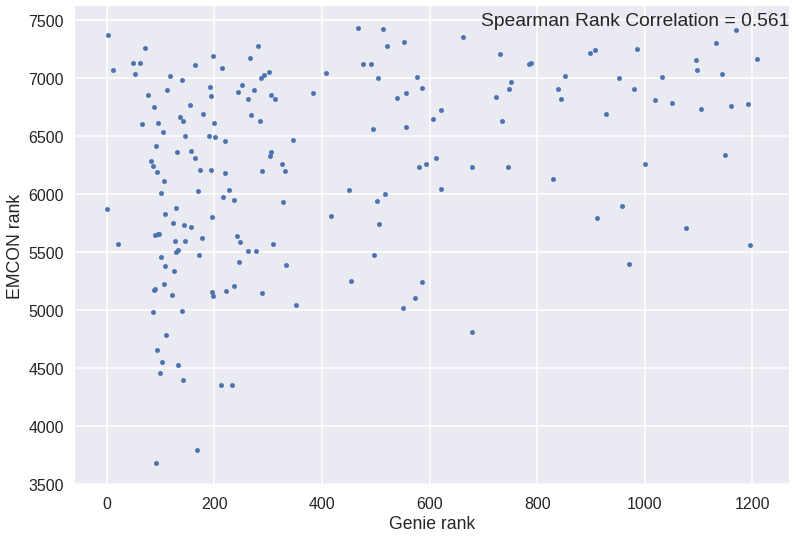

In [52]:
results = pd.DataFrame([pd.Series(genie_results.loc[bc_genes].Rank),
#              bc_results.rank(ascending=False,na_option="bottom").loc[bc_genes].npmi
               bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes]
                       ],
             index=["Genie rank","EMCON rank"]).T
ax = plt.subplot()
results.plot(x="Genie rank",y="EMCON rank",kind="scatter",ax=ax)
ax.text(1,0.96,f"Spearman Rank Correlation = {round(spearmanr(results.values)[0],3)}",
        horizontalalignment="right",
        transform=ax.transAxes)
# results2 = pd.DataFrame([pd.Series(genie_results_bn.loc[bc_genes].Rank),
# #              bc_results.rank(ascending=False,na_option="bottom").loc[bc_genes].npmi
#                bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes]
#                         ],
#              index=["Genie rank","EMCON rank"]).T
# results2.plot(x="Genie rank",y="EMCON rank",kind="scatter",ax=ax,c="g")
# ax2.text(0.95,0.91,f"Spearman Rank Correlation = {round(spearmanr(results2.values)[0],3)}",
#         horizontalalignment="right",
#         transform=ax.transAxes)
# plt.title("""Rank Correlation of ESR gene set\nGenie Results using 214 MeSH terms compared to EMCON""")
plt.savefig("genie_comp_all_mesh_terms.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [40]:
len(genie_results),len(bc_results),len(genie_results_bn)

(1235, 14811, 1777)

In [41]:
spearmanr(results.values)

SpearmanrResult(correlation=0.56110471363374059, pvalue=3.3293158079557996e-25)

In [37]:
genie_results_bn = pd.read_table(
    "../data/SSI/genie_results_breast_neoplasms_20170718153344381245235_table.txt").set_index("GeneID")

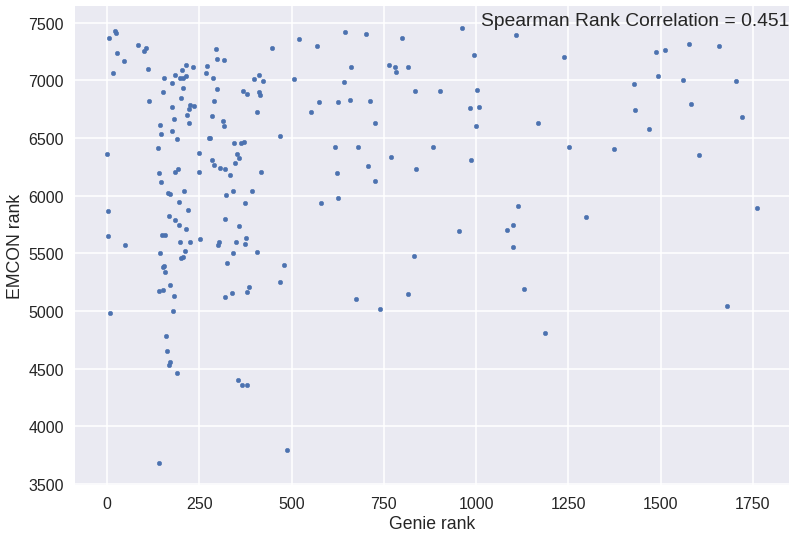

In [57]:
results2 = pd.DataFrame([pd.Series(genie_results_bn.loc[bc_genes].Rank),
#              bc_results.rank(ascending=False,na_option="bottom").loc[bc_genes].npmi
               bc_results.swaplevel(0,1,axis=1).npmi_rank.mean(axis=1)[bc_genes]
                        ],
             index=["Genie rank","EMCON rank"]).T
ax = plt.subplot()
results2.plot(x="Genie rank",y="EMCON rank",kind="scatter",ax=ax)
ax.text(1,0.96,f"Spearman Rank Correlation = {round(spearmanr(results2.values)[0],3)}",
        horizontalalignment="right",
        transform=ax.transAxes)
# plt.title("""Rank Correlation of ESR gene set\nGenie Results using "Breast Neoplasms" compared to EMCON""")
plt.savefig("genie_comp_bn.jpeg",dpi=500,transparent=False,bbox_inches="tight")

In [43]:
spearmanr(results2.values)

SpearmanrResult(correlation=0.4509739672233351, pvalue=8.7646765747990618e-16)

In [119]:
results[results["Genie rank"].isnull()].index.values

array([  2052,   1543,   1544,      9,     10,   1548,   1555,   1557,
         1558,   1559,   5648,  83990,   1562,   4128,   4129,   1571,
         1573,   7718,   1577,   8745,  79915,   3122,   2104,  10309,
        23621,   3158,  54361,   5727,   2660,   7799,    134,    135,
          652,   3726,  58508,   8577,    148,   5016,   5788,   6300,
         5792,   6818,   6822,   8370,   4287,   4292,   5327,  64210,
         1244,    226,   4835,   3312,   5360,   9970,   5890,   6926,
         6927,   6416, 112398,   1812,   5916,   4893,   3358,   3361,
         3362,   3363,   8996,   5423,   2353,   7480,   2877,   5451,
          338,    345,    347,  57178,  10599,   9577,   2939,   4987,
         4988,   2944,   3456,   2946,   6531,   2952,  54658,   7056,
         2990,  29108,    952,   4025,   9156,   8647,    969,  79365,
        66002,   2004,   3562,   5609,   3565,   2547,   6132])

In [121]:
results2[results2["Genie rank"].isnull()].index.values

array([ 1548,  5648,  1562,  4128,  4129,  1573,  7718,  3623,  3624,
        3625,  8745, 79915,  3122,  6720, 10309, 23621,  3158, 54361,
        5727,  2660,   134,   135,   652, 58508,  8577,   148,  5016,
        5788,  5792,  6818,  6822,  8370,  4287,   706,  8900,  5327,
       64210,   226, 10468,  5360,  9970,  6927,  1812,  5916,  4893,
        3358,  3361,  3362,  3363,  8996,  7480,  2877,  5451,   338,
         345,   347,  9577,  1906,  2939,  4987,  4988,  3456,  2946,
        3972,  6531,  7043,  7056,  7067,  2990,   952,  4025,  9156,
        8647,   969, 66002,  2004,  3558,  3562,  5609,  3565,  6132])